In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
def calc_ols(df1, s1, s2, smoothing):
    
    pair=df1.iloc[:, [s1, s2]]
    pair.dropna(how='any', axis=0, inplace=True)
    
    if smoothing=='yes':
        pair=pair.rolling(window=5).mean()
        pair.dropna(inplace=True)
        
    c=np.polyfit(pair.iloc[:, 0], pair.iloc[:, 1],  1, full=False)
    temp_list=pair.iloc[:, 1]-c[0]*pair.iloc[:, 0]
    
    return c[0], temp_list

In [3]:
start=date(1990, 1, 1)
end=date(2020, 11, 16)

stock_list=['A', 'PKI']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()

In [4]:
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
#print(c)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash.head()
dog_leash=dog_leash[['Dog_leash']]

In [5]:
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data.head()

,Date,A,PKI,Dog_leash
0,1999-11-24,25.437859,16.889872,-13.338301
1,1999-11-26,25.515301,17.088282,-12.988633
2,1999-11-29,26.096071,16.914673,-13.317646
3,1999-11-30,26.134789,16.319437,-13.252357
4,1999-12-01,26.599405,16.493044,-13.739261


c:\program files\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\program files\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\program files\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              Dog_leash   No. Observations:                 5278
Model:               SARIMAX(7, 0, 5)   Log Likelihood                 449.846
Date:                Sat, 21 Nov 2020   AIC                           -873.692
Time:                        21:26:32   BIC                           -788.265
Sample:                             0   HQIC                          -843.833
                               - 5278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0525      0.154      0.341      0.733      -0.249       0.354
ar.L2          0.8984      0.149      6.015      0.000       0.606       1.191
ar.L3          0.0613      0.006      9.431      0.0

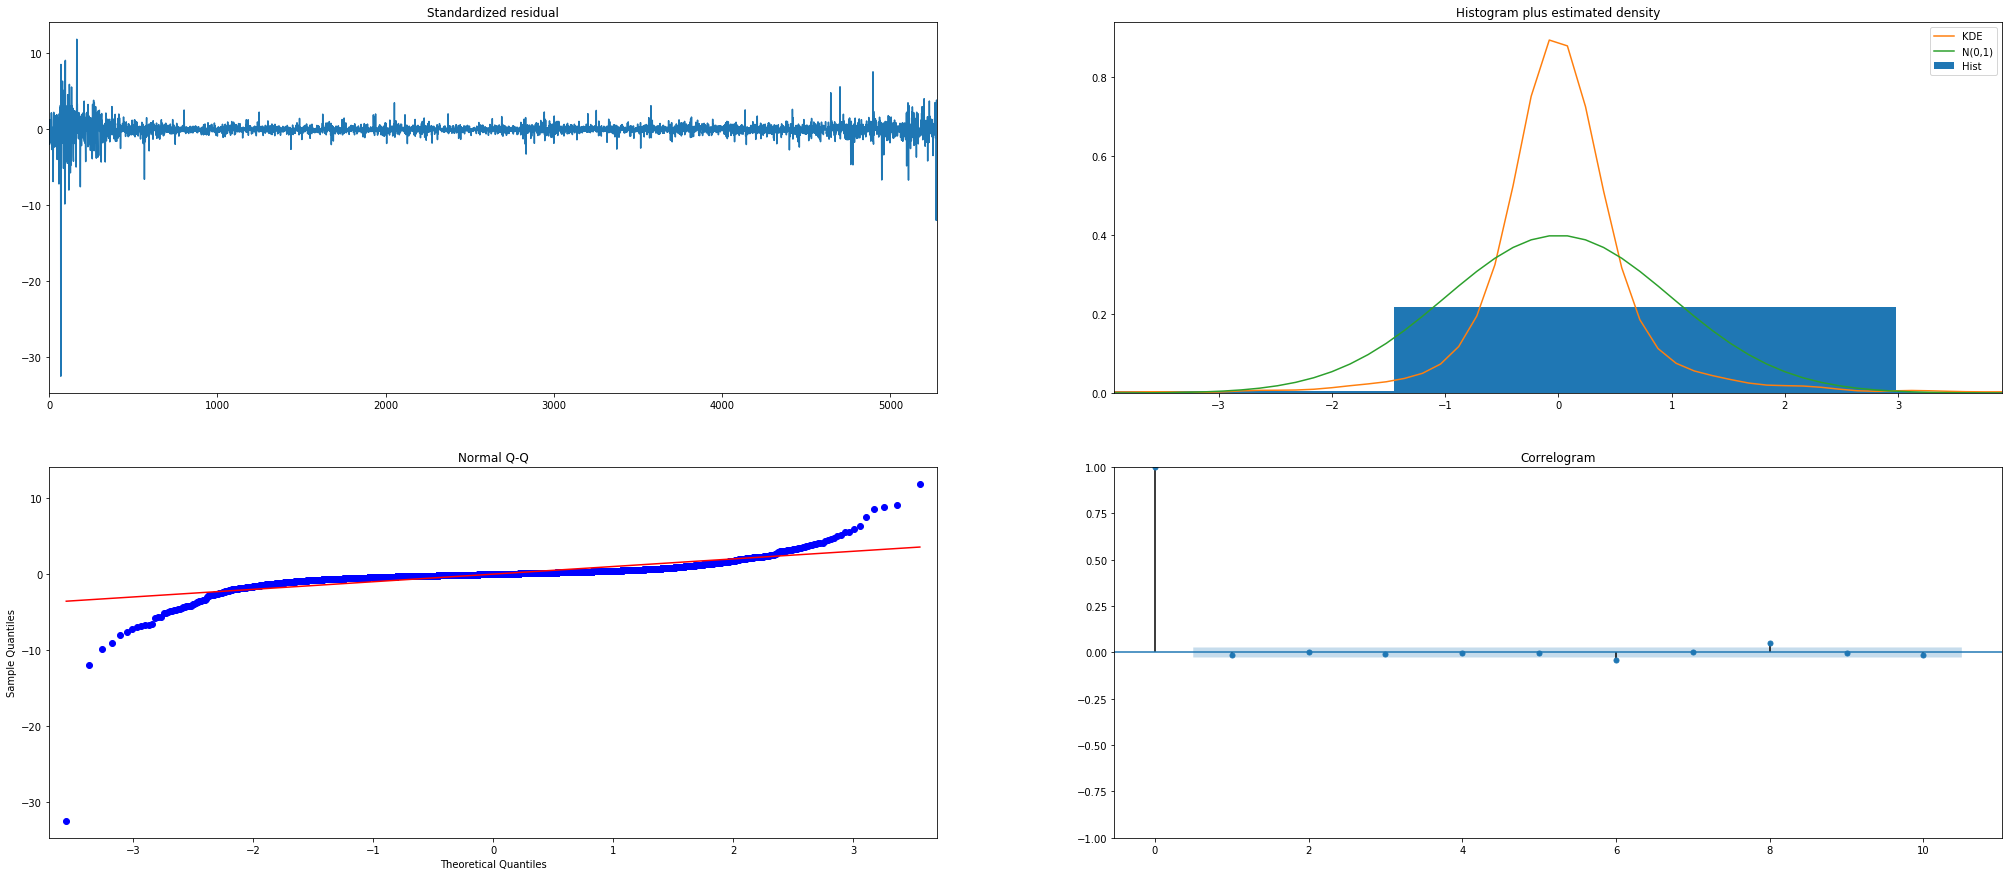

In [6]:
model=SARIMAX(test_data.Dog_leash, order=(7, 0, 5))
results=model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(35,15))
plt.show()

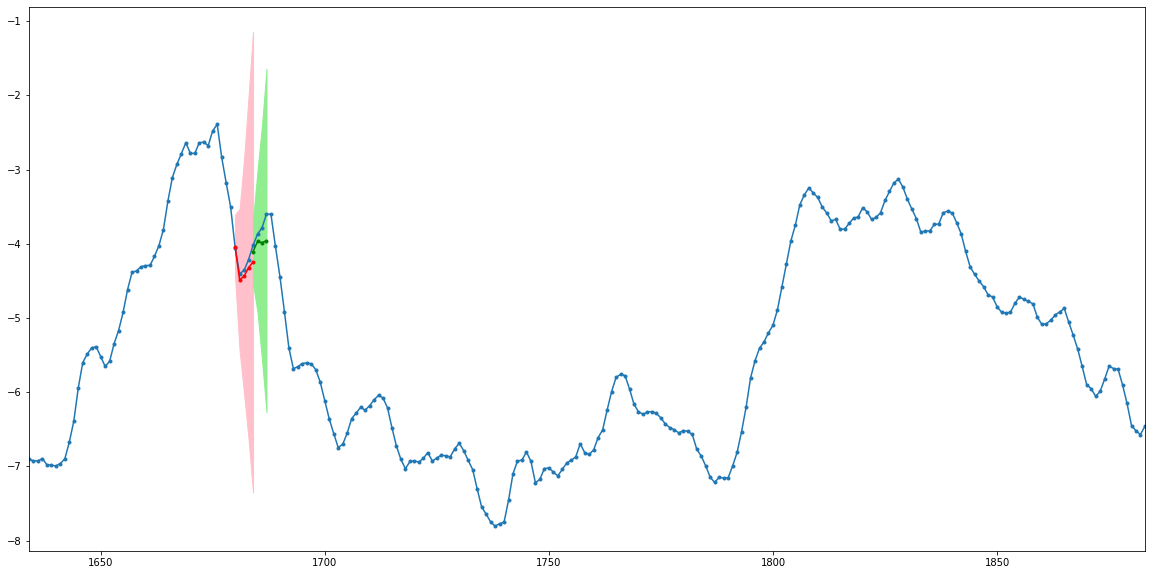

1684
-0.44505724989487927
0.04733793130979258
0.11753886579936879
0.13730555076694406
-0.01587039419666869
0.026393469037385042


In [7]:
test_start=-3700-71+177
back_forecast=results.get_prediction(start=test_start-4, end=test_start, dynamic=True)
for_forecast=results.get_prediction(start=test_start, end=test_start+3, dynamic=True)
mean_forecast=back_forecast.predicted_mean
mean_predict=for_forecast.predicted_mean

conf_intervals=back_forecast.conf_int()
for_intervals=for_forecast.conf_int()
#conf_intervals.head()
plt.figure(figsize=(20,10))
test_data.Dog_leash[test_start-50:test_start+200].plot(marker='.')
plt.plot(mean_forecast.index, mean_forecast.values, color='red', marker='.', label='forecast')
plt.plot(mean_predict.index, mean_predict.values, color='green', marker='.', label='prediction')
plt.fill_between(conf_intervals.index, conf_intervals['lower Dog_leash'], conf_intervals['upper Dog_leash'], color='pink')
plt.fill_between(for_intervals.index, for_intervals['lower Dog_leash'], for_intervals['upper Dog_leash'], color='lightgreen')
plt.show()
print(len(test_data.index)+test_start)
first_var=mean_forecast[len(test_data.index)+test_start-3]-mean_forecast[len(test_data.index)+test_start-4]
second_var=mean_forecast[len(test_data.index)+test_start-2]-mean_forecast[len(test_data.index)+test_start-3]
third_var=mean_forecast[len(test_data.index)+test_start-1]-mean_forecast[len(test_data.index)+test_start-2]
first_var_f=mean_predict[len(test_data.index)+test_start+1]-mean_predict[len(test_data.index)+test_start]
second_var_f=mean_predict[len(test_data.index)+test_start+2]-mean_predict[len(test_data.index)+test_start+1]
third_var_f=mean_predict[len(test_data.index)+test_start+3]-mean_predict[len(test_data.index)+test_start+2]
print(first_var)
print(second_var)
print(third_var)
print(first_var_f)
print(second_var_f)
print(third_var_f)

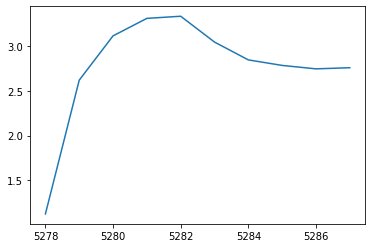

In [8]:
for_forecast=results.get_forecast(steps=10)
fut_forecast=for_forecast.predicted_mean
plt.plot(fut_forecast)

In [54]:
fut_forecast

3771    40.197057
3772    40.814392
3773    41.853145
3774    42.479332
3775    42.575384
3776    42.520056
3777    42.403294
3778    42.319499
3779    42.195615
3780    42.033488
dtype: float64

In [43]:
cur_trend=0 #initiate current trend with 0
profit=0
p_l=0
test_start=-3700
main_list=[]
temp_list=[]
pos_open=False

for i in range(test_start,-4):
    
    start_point=len(test_data.index)+i

    back_forecast=results.get_prediction(start=i-3, end=i, dynamic=True)
    mean_forecast=back_forecast.predicted_mean
    
    first_var=test_data.iloc[start_point-3,3]-mean_forecast[start_point-3]
    second_var=test_data.iloc[start_point-2,3]-mean_forecast[start_point-2]
    third_var=test_data.iloc[start_point-1,3]-mean_forecast[start_point-1]

#############################down:-1, up:1, sideway:0###############################
    if first_var>third_var:
        trend_id=-1 
    if first_var<third_var:
        trend_id=1


############################trading sequence#######################
    if trend_id>cur_trend: #Initiate the opening position
        position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
        temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], 0, c[0], 'O']
        main_list.append(temp_list)
        test_start=i
        cur_trend=trend_id
        pos_open=True
        break
    if trend_id<cur_trend:
        position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
        temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], 0, c[0], 'O']
        main_list.append(temp_list)
        test_start=i
        cur_trend=trend_id
        pos_open=True
        break 

#print(main_list)
#print(cur_trend)
#print(test_start)

In [11]:
for i in range(test_start+1,-4):
    
    start_point=len(test_data.index)+i

    back_forecast=results.get_prediction(start=i-3, end=i, dynamic=True)
    mean_forecast=back_forecast.predicted_mean
    
    first_var=test_data.iloc[start_point-3,3]-mean_forecast[start_point-3]
    second_var=test_data.iloc[start_point-2,3]-mean_forecast[start_point-2]
    third_var=test_data.iloc[start_point-1,3]-mean_forecast[start_point-1]

##############################down:-1, up:1, sideway:0###############################
    if first_var>third_var:
        trend_id=-1 
    if first_var<third_var:
        trend_id=1


#############################trading sequence#######################
    if trend_id>cur_trend and pos_open:
        position1=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
        p_l=-position1-position0
        if p_l>0:
            profit=profit+p_l
            temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], p_l, c[0], 'C']
            main_list.append(temp_list)
            
            position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
            temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], 0, c[0], 'O']
            main_list.append(temp_list)
            pos_open=True
            cur_trend=trend_id

    if trend_id<cur_trend and pos_open:
        position1=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
        p_l=-position1-position0
        if p_l>0:
            profit=profit+p_l
            temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], p_l, c[0], 'C']
            main_list.append(temp_list)
            
            position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
            temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], 0, c[0], 'O']
            main_list.append(temp_list) 
            pos_open=True
            cur_trend=trend_id


    #if trend_id>cur_trend and not pos_open:
    #    position0=test_data.iloc[start_point, 2]-c[0]*test_data.iloc[start_point, 1]
    #    temp_list=[start_point, -test_data.iloc[start_point, 1], test_data.iloc[start_point, 2], 0, 'O']
    #    main_list.append(temp_list)
    #    pos_open=True
    #if trend_id<cur_trend and not pos_open:
    #    position0=c[0]*test_data.iloc[start_point, 1]-test_data.iloc[start_point, 2]
    #    temp_list=[start_point, test_data.iloc[start_point, 1], -test_data.iloc[start_point, 2], 0, 'O']
    #    main_list.append(temp_list) 
    #    pos_open=True
        
    #cur_trend=trend_id 


In [12]:
main_list

[[71, 10.741765022277832, -61.62717819213867, 0, 1.6571585899860746, 'O'],
 [78,
  -12.358746528625488,
  61.53574752807617,
  2.7710254571551403,
  1.6571585899860746,
  'C'],
 [78, -12.358746528625488, 61.53574752807617, 0, 1.6571585899860746, 'O'],
 [83,
  12.195413589477539,
  -61.86491012573242,
  0.5998311807929468,
  1.6571585899860746,
  'C'],
 [83, 12.195413589477539, -61.86491012573242, 0, 1.6571585899860746, 'O'],
 [84,
  -12.676335334777832,
  62.28553009033203,
  0.3763436367358679,
  1.6571585899860746,
  'C'],
 [84, -12.676335334777832, 62.28553009033203, 0, 1.6571585899860746, 'O'],
 [87,
  12.943108558654785,
  -62.83079147338867,
  0.10317584353067133,
  1.6571585899860746,
  'C'],
 [87, 12.943108558654785, -62.83079147338867, 0, 1.6571585899860746, 'O'],
 [117,
  -13.716211318969727,
  63.40165710449219,
  0.710288249094333,
  1.6571585899860746,
  'C'],
 [117, -13.716211318969727, 63.40165710449219, 0, 1.6571585899860746, 'O'],
 [130,
  10.115659713745117,
  -64.745

In [13]:
profit

47.56034349172805

In [14]:
test_results=pd.DataFrame(main_list, columns=('day_index', 'low_pos', 'high_pos', 'p_l', 'coef', 'Trade_type'))
test_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 6 columns):
day_index     43 non-null int64
low_pos       43 non-null float64
high_pos      43 non-null float64
p_l           43 non-null float64
coef          43 non-null float64
Trade_type    43 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
test_results.to_csv('C:/Program Files/Python37/workshop/stock_strategies/Pair trade_Time_series/data/back_test.csv')